# Tutorial 1: Training a spiking neural network with surrogate gradients

Friedemann Zenke (https://fzenke.net)

> For more details on surrogate gradient learning, please see: 
> Neftci, E.O., Mostafa, H., and Zenke, F. (2019). Surrogate Gradient Learning in Spiking Neural Networks.
> https://arxiv.org/abs/1901.09948

## Introduction 

The last months have seen a surge of interest in training spiking neural networks to do meaningful computations. On the one hand, this surge was fueled by the limited accomplishment of more traditional, and often considered more biologically plausible, learning paradigms in creating functional neural networks that solve interesting computational problems. This limitation was met by the undeniable success of deep neural networks in acing a diversity of challenging computational problems. A success that has raised both the bar and the question of how well this progress would translate to spiking neural networks.

The rise of deep learning over the last decade is in large part due to GPUs and their increased computational power, growing training data sets, and --- perhaps most importantly --- advances in understanding the quirks and needs of the error back-propagation algorithm. For instance, we now know that we have to avoid vanishing and exploding gradients, a feat that can be accomplished by choice of a sensible nonlinearity, proper weight initialization, and a suitable optimizer. Powerful software packages supporting auto-differentiation have since made mangling with deep neural networks a breeze in comparison to what it used to be. This development begs the question of how much of this knowledge gain from deep learning and its tools we can leverage to train spiking neural networks. Although a complete answer to these questions cannot be given at the moment, it seems that we can learn a lot.

In this tutorial, we use insights and tools from machine learning to build, step-by-step, a spiking neural network. Explicitly, we set out with the goal of building networks that solve (simple) real-world problems. To that end, we focus on classification problems and use supervised learning in conjunction with the aforementioned back-propagation algorithm. To do this, we have to overcome a vanishing gradient problem caused by the binary nature of the spikes themselves.

In this tutorial, we will first show how a simple feed-forward spiking neural network of leaky integrate-and-fire (LIF) neurons with current-based synapses can be formally mapped to a discrete-time recurrent neural network (RNN). We will use this formulation to explain why gradients vanish at spikes and show one way of how the problem can be alleviated. Specifically, we will introduce surrogate gradients and provide practical examples of how they can be implemented in PyTorch.

## 소개

지난 몇 달 동안 의미 있는 계산을 수행하기 위해 급증하는 신경망을 훈련시키는 데 대한 관심이 급증했습니다. 한편으로 이러한 급증은 흥미로운 계산 문제를 해결하는 기능적 신경망을 만드는 데 있어서 보다 전통적이고 생물학적으로 더 타당하다고 여겨지는 학습 패러다임의 제한된 성취에 의해 촉진되었습니다. 이러한 한계는 다양한 까다로운 계산 문제를 해결하는 데 있어서 심층 신경망의 부인할 수 없는 성공으로 인해 충족되었습니다. 이러한 진전이 신경망 급증으로 얼마나 잘 변환될지에 대한 기준과 질문을 모두 높인 성공입니다.

지난 10년 동안 딥 러닝이 부상한 데에는 GPU와 GPU의 계산 능력 증가, 훈련 데이터 세트의 증가, 그리고 아마도 가장 중요하게는 오류 역전파의 특징과 필요성에 대한 이해의 발전이 크게 기여했습니다. 연산. 예를 들어, 이제 우리는 기울기가 사라지고 폭발하는 것을 피해야 한다는 것을 알고 있습니다. 이는 합리적인 비선형성, 적절한 가중치 초기화 및 적합한 최적화 프로그램을 선택하여 달성할 수 있는 위업입니다. 자동 차별화를 지원하는 강력한 소프트웨어 패키지 덕분에 예전보다 심층 신경망을 이용한 맹글링이 쉬워졌습니다. 이러한 발전은 급증하는 신경망을 훈련하는 데 활용할 수 있는 딥 러닝과 도구를 통해 이러한 지식이 얼마나 많이 얻어지는지에 대한 의문을 제기합니다. 현재로서는 이러한 질문에 대한 완전한 답을 줄 수는 없지만 많은 것을 배울 수 있는 것 같습니다.

이 튜토리얼에서는 기계 학습의 통찰력과 도구를 사용하여 급증하는 신경망을 단계별로 구축합니다. 명시적으로 우리는 (간단한) 실제 문제를 해결하는 네트워크 구축이라는 목표를 가지고 출발했습니다. 이를 위해 우리는 분류 문제에 중점을 두고 앞서 언급한 역전파 알고리즘과 함께 지도 학습을 사용합니다. 이를 위해서는 스파이크 자체의 이진 특성으로 인해 발생하는 그래디언트 소실 문제를 극복해야 합니다.

이 튜토리얼에서는 먼저 전류 기반 시냅스를 갖춘 LIF(Leaky Integration-and-Fire) 뉴런으로 구성된 간단한 피드포워드 스파이크 신경망이 이산시간 순환 신경망(RNN)에 공식적으로 매핑될 수 있는 방법을 보여줍니다. 우리는 이 공식을 사용하여 왜 경사도가 스파이크에서 사라지는지 설명하고 문제를 완화할 수 있는 한 가지 방법을 보여줄 것입니다. 구체적으로 대리 그래디언트를 소개하고 PyTorch에서 어떻게 구현될 수 있는지에 대한 실제적인 예를 제공합니다.

## Mapping LIF neurons to RNN dynamics

The de-facto standard neuron model for network simulations in computational neuroscience is the LIF neuron model which is often formally written as a time continuous dynamical system in differential form:
$$\tau_\mathrm{mem} \frac{\mathrm{d}U_i^{(l)}}{\mathrm{d}t} = -(U_i^{(l)}-U_\mathrm{rest}) + RI_i^{(l)}$$
where $U_i$ is the membrane potential of neuron $i$ in layer $l$, $U_\mathrm{rest}$ is the resting potential, $\tau_\mathrm{mem}$ is the membrane time constant, $R$ is the input resistance, and $I_i$ is the input current. The membrane potential $U_i$ characterizes the hidden state of each neuron and, importantly, it is not directly communicated to downstream neurons. However, a neuron fires an action potential or spike at the time $t$ when its membrane voltage exceeds the firing threshold $\vartheta$. After having fired a spike, a neurons membrane voltage is reset $U_i \rightarrow U_\mathrm{rest}$. We write
$$S_i^{(l)}(t)=\sum_{k \in C_i^l} \delta(t-t_j^k)$$ 
for the spike train (ie. the sum of all spikes $C_i^l$ emitted by neuron $i$ in layer $l$). Here $\delta$ is the Dirac delta function and $t_i^k$ are the associated firing times of the neuron.

Spikes travel down the axon and generate a postsynaptic currents in connected neurons. Using our above formalism we can thus write
$$\frac{\mathrm{d}I_i}{\mathrm{d}t}= -\frac{I_i(t)}{\tau_\mathrm{syn}} + \sum_j W_{ij} S_j^{(0)}(t) + \sum_j V_{ij} S_j^{(1)}(t)$$
where we have introduced the synaptic weight matrices $W_{ij}$ (feed-forward), $V_{ij}$ (recurrent), and the synaptic decay time constant $\tau_\mathrm{syn}$.

To link to RNNs apparent, we will now express the above equations in discrete time. In the interest of brevity we switch to natural units $U_\mathrm{rest}=0$, $R=1$, and $\vartheta=1$. Our arguments remain unaffected by this choice, and all results can always be re-scaled back to physical units. To highlight the nonlinear character of a spike, we start by noting that we can set
$$S_i^{(l)}(t)=\Theta(U_i^{(l)}(t)-\vartheta)$$
where $\Theta$ denotes the Heaviside step function.

Assuming a small simulation time step of $\Delta_t>0$ we can approximate the synaptic dynamics by
$$I_i^{(l)}(t+1) = \alpha I_i^{(l)}(t) + \sum_j W_{ij} S_j^{(l-1)}(t) +\sum_j V_{ij} S_j^{(l)}(t)$$
with the constant $\alpha=\exp\left(-\frac{\Delta_t}{\tau_\mathrm{syn}} \right)$. Further, the membrane dynamics can be written as
$$U_i^{(l)}(t+1) = \underbrace{\beta U_i^{(l)}(t)}_{\mathrm{leak}} + \underbrace{I_i^{(l)}(t)}_{\mathrm{input}} -\underbrace{S_i^{(l)}(t)}_{\mathrm{reset}}$$
with the output $S_i(t) = \Theta(U_i(t)-1)$ and the constant $\beta=\exp\left(-\frac{\Delta_t}{\tau_\mathrm{mem}}\right)$. Note the distinct terms on the right-hand-side of the equation which are responsible individually for i) leak, ii) synaptic input, and iii) the spike reset.



These equations can be summarized succinctly as the computational graph of an RNN with a specific connectivity structure. 
<img src="figures/snn_graph/snn_graph.png" width="450">
Time flows from left to right. Inputs enter the network at each time step from the bottom of the graph ($S_i^{(0)}$). These inputs sequentially influence the synaptic currents $I_i^{(1)}$, membrane potentials the $U_i^{(1)}$, and finally the spiking output $S_i^{(1)}$.  Moreover, dynamic quantities have direct input on future time steps. We have suppressed the indices $i$ in the figure for clarity.

The computational graph illustrates a concept which is known as unrolling in time, which emphasizes the duality between a deep neural network and a recurrent neural network, which is nothing more but a deep network in time (with tied weights). Due to this fact, we can train RNNs using the back-propagation of error through time (BPTT). We will discuss problems arising from the binary character of the spiking nonlinearity later. For now, let us start by implementing the above dynamics in a three-layer spiking neural network in PyTorch.

## LIF 뉴런을 RNN 역학에 매핑

전산 신경과학에서 네트워크 시뮬레이션을 위한 사실상의 표준 뉴런 모델은 공식적으로 미분 형식의 시간 연속 동적 시스템으로 작성되는 LIF 뉴런 모델입니다.
$$\tau_\mathrm{mem} \frac{\mathrm{d}U_i^{(l)}}{\mathrm{d}t} = -(U_i^{(l)}-U_\mathrm{rest} ) + RI_i^{(l)}$$
여기서 $U_i$는 $l$ 층에 있는 뉴런 $i$의 막 전위이고, $U_\mathrm{rest}$는 휴지 전위이고, $\tau_\mathrm{mem}$은 막 시간 상수, $R$입니다. 는 입력 저항이고 $I_i$는 입력 전류입니다. 막 전위 $U_i$는 각 뉴런의 숨겨진 상태를 특징으로 하며, 중요한 것은 이것이 하류 뉴런에 직접 전달되지 않는다는 것입니다. 그러나 뉴런은 막 전압이 발화 역치 $\vartheta$를 초과하는 $t$ 시점에 활동 전위 또는 스파이크를 발생시킵니다. 스파이크가 발생한 후 뉴런 막 전압은 $U_i \rightarrow U_\mathrm{rest}$로 재설정됩니다. 우리는 쓴다
$$S_i^{(l)}(t)=\sum_{k \in C_i^l} \delta(t-t_j^k)$$
스파이크 트레인(즉, $l$ 레이어의 $i$ 뉴런이 방출하는 모든 스파이크 $C_i^l$의 합). 여기서 $\delta$는 Dirac delta 함수이고 $t_i^k$는 뉴런의 관련 발사 시간입니다.

스파이크는 축색돌기를 따라 이동하여 연결된 뉴런에 시냅스후 전류를 생성합니다. 위의 형식을 사용하여 다음과 같이 작성할 수 있습니다.
$$\frac{\mathrm{d}I_i}{\mathrm{d}t}= -\frac{I_i(t)}{\tau_\mathrm{syn}} + \sum_j W_{ij} S_j^{( 0)}(t) + \sum_j V_{ij} S_j^{(1)}(t)$$
여기서 우리는 시냅스 가중치 행렬 $W_{ij}$(피드포워드), $V_{ij}$(반복) 및 시냅스 붕괴 시간 상수 $\tau_\mathrm{syn}$를 도입했습니다.

명백한 RNN에 연결하기 위해 이제 위의 방정식을 이산 시간으로 표현하겠습니다. 간결성을 위해 자연 단위 $U_\mathrm{rest}=0$, $R=1$ 및 $\vartheta=1$로 전환합니다. 우리의 주장은 이 선택에 영향을 받지 않으며 모든 결과는 항상 물리적 단위로 다시 조정될 수 있습니다. 스파이크의 비선형 특성을 강조하기 위해 먼저 다음을 설정할 수 있다는 점에 주목합니다.
$$S_i^{(l)}(t)=\Theta(U_i^{(l)}(t)-\vartheta)$$
여기서 $\Theta$는 헤비사이드 계단 함수를 나타냅니다.

$\Delta_t>0$의 작은 시뮬레이션 시간 간격을 가정하면 다음과 같이 시냅스 역학을 근사화할 수 있습니다.
$$I_i^{(l)}(t+1) = \alpha I_i^{(l)}(t) + \sum_j W_{ij} S_j^{(l-1)}(t) +\sum_j V_ {ij} S_j^{(l)}(t)$$
상수 $\alpha=\exp\left(-\frac{\Delta_t}{\tau_\mathrm{syn}} \right)$를 사용합니다. 또한, 막 역학은 다음과 같이 쓸 수 있습니다.
$$U_i^{(l)}(t+1) = \underbrace{\beta U_i^{(l)}(t)}_{\mathrm{누출}} + \underbrace{I_i^{(l)} (t)}_{\mathrm{input}} -\underbrace{S_i^{(l)}(t)}_{\mathrm{reset}}$$
출력 $S_i(t) = \Theta(U_i(t)-1)$ 및 상수 $\beta=\exp\left(-\frac{\Delta_t}{\tau_\mathrm{mem}}\right )$. i) 누출, ii) 시냅스 입력 및 iii) 스파이크 재설정을 개별적으로 담당하는 방정식의 오른쪽에 있는 고유한 용어에 유의하십시오.



이러한 방정식은 특정 연결 구조를 가진 RNN의 계산 그래프로 간결하게 요약될 수 있습니다.
<img src="Figures/snn_graph/snn_graph.png" width="450">
시간은 왼쪽에서 오른쪽으로 흐른다. 그래프 하단($S_i^{(0)}$)부터 각 시간 단계마다 입력이 네트워크에 입력됩니다. 이러한 입력은 순차적으로 시냅스 전류 $I_i^{(1)}$, 막 전위 $U_i^{(1)}$, 마지막으로 스파이크 출력 $S_i^{(1)}$에 영향을 미칩니다. 더욱이 동적 수량은 미래 시간 단계에 대한 직접적인 입력을 갖습니다. 명확성을 위해 그림에서 인덱스 $i$를 표시하지 않았습니다.

계산 그래프는 시간에 따른 언롤링(unrolling in time)이라는 개념을 보여줍니다. 이는 심층 신경망과 순환 신경망(연결된 가중치가 있는) 시간에 따른 심층 신경망에 지나지 않는 순환 신경망 사이의 이중성을 강조합니다. 이러한 사실로 인해 우리는 시간을 통한 오류의 역전파(BPTT)를 사용하여 RNN을 훈련할 수 있습니다. 스파이크 비선형성의 이진 특성으로 인해 발생하는 문제는 나중에 논의하겠습니다. 지금은 PyTorch의 3계층 스파이킹 신경망에서 위의 역학을 구현하는 것부터 시작하겠습니다.

## Example network

Let's start with a simple multilayer network model with a single hidden layer, as shown below. For simplicity, we will not use recurrent connections $V$ for now, keeping in mind that they can be added later should the need arise.

<img src="figures/mlp_sketch/mlp_sketch.png">

For the sake of argument, we set the numbers for the input, hidden and output neurons as follows:

아래와 같이 단일 히든 레이어가 있는 간단한 다층 네트워크 모델부터 시작해 보겠습니다. 단순화를 위해 지금은 반복 연결 $V$를 사용하지 않을 것이며 나중에 필요할 경우 추가할 수 있다는 점을 염두에 두어야 합니다.

<img src="Figures/mlp_sketch/mlp_sketch.png">

논의를 위해 입력, 은닉 및 출력 뉴런의 숫자를 다음과 같이 설정합니다.

In [1]:
# RNN 구축을 위한 변수 생성
# nb: number of

nb_inputs  = 100    # 입력 노드 개수
nb_hidden  = 4      # 은닉 노드 개수
nb_outputs = 2      # 출력 노드 개수

As we have seen above, we are technically simulating an RNN. Thus we have to simulate our neurons for a certain number of timesteps. We will use 1ms timesteps, and we want to simulate our network for say 200 timesteps. 

위에서 본 것처럼 우리는 RNN을 기술적으로 시뮬레이션하고 있습니다. 따라서 우리는 특정 시간 단계에 대해 뉴런을 시뮬레이션해야 합니다. 우리는 1ms의 시간 단계를 사용할 것이며, 200개의 시간 단계에 대해 네트워크를 시뮬레이션하려고 합니다.

In [2]:
time_step = 1e-3    # 시간 상수
nb_steps  = 200     # 시간 상수의 개수(200단계의 상황에 대해 시뮬레이션)

To take advantage of parallelism, we will set up our code to work on batches of data like this is usually done for neural networks that are trained in a supervised manner.
To that end, we specify a batch size here.

병렬성을 활용하기 위해 감독 방식으로 훈련된 신경망에서 일반적으로 수행되는 것과 같이 일괄 데이터에 대해 작업하도록 코드를 설정합니다.
이를 위해 여기서는 배치 크기를 지정합니다.

In [3]:
batch_size = 256    # 신경망 학습의 배치 크기

With these basic design choices made, we can now start building the actual network. Here we will be using PyTorch, but you will be able to reproduce these results in most common machine learning libraries.

We start by importing the libraries we need.

이러한 기본 설계 선택을 통해 이제 실제 네트워크 구축을 시작할 수 있습니다. 여기서는 PyTorch를 사용하지만 가장 일반적인 기계 학습 라이브러리에서 이러한 결과를 재현할 수 있습니다.

필요한 라이브러리를 가져오는 것부터 시작합니다.

In [7]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn

In [8]:
dtype = torch.float
device = torch.device("cpu")    # cpu 설정

# Uncomment the line below to run on GPU
# device = torch.device("cuda:0") 

### A simple synthetic dataset 

We start by generating some random spiking data set, which we will use as input to our network. In the beginning, we will work with a single batch of data. It will be straight forward to expand later what we have learned to larger datasets.

Suppose we want our network to classify a set of different sparse input spike trains into two categories. 

To generate some synthetic data, we fill a tensor of (batch_size x nb_steps x nb_inputs) with random uniform numbers between 0 and 1 and use this to generate our input dataset:

### 간단한 합성 데이터세트

우리는 네트워크에 대한 입력으로 사용할 임의의 스파이크 데이터 세트를 생성하는 것부터 시작합니다. 처음에는 단일 데이터 배치로 작업합니다. 나중에 우리가 배운 내용을 더 큰 데이터세트로 확장하는 것은 간단할 것입니다.

네트워크가 서로 다른 희소 입력 스파이크 열차 세트를 두 가지 범주로 분류하기를 원한다고 가정합니다.

합성 데이터를 생성하기 위해 (batch_size x nb_steps x nb_inputs)의 텐서를 0과 1 사이의 임의의 균일수로 채우고 이를 사용하여 입력 데이터 세트를 생성합니다.

In [9]:
freq = 5 # Hz(주파수)
prob = freq*time_step

# 0~1의 임의의 균일수로 채우기
mask = torch.rand((batch_size,nb_steps,nb_inputs), device=device, dtype=dtype)

# 입력데이터 생성
x_data = torch.zeros((batch_size,nb_steps,nb_inputs), device=device, dtype=dtype, requires_grad=False)
x_data[mask<prob] = 1.0     # 임의의 값과 비교해 mask보다 크면 1.0으로 지정

print("freq 주파수:", freq)
print("prob 주파수*시간간격:", prob)
print("time_step 시간간격:", time_step)
print("mask.shape:", mask.shape)
print("x_data.shape 입력데이터:", x_data.shape)

freq 주파수: 5
prob 주파수*시간간격: 0.005
time_step 시간간격: 0.001
mask.shape: torch.Size([256, 200, 100])
x_data.shape 입력데이터: torch.Size([256, 200, 100])


If the plot the spike raster of the first input pattern, this synthetic dataset looks as follows.

첫 번째 입력 패턴의 스파이크 래스터를 플롯하면 이 합성 데이터세트는 다음과 같습니다.

#2024-03-28 checkpoint

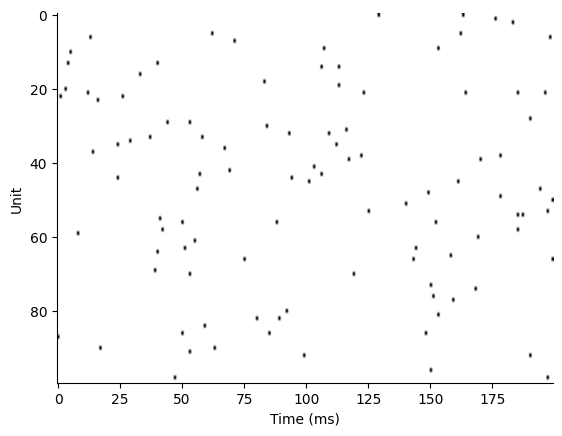

In [11]:
# 데이터를 확인하기 위한 코드

data_id = 0                 # 확인할 데이터 id

# cpu() -> 토치에서는 gpu, cpu 공간을 따로 보며, cpu 공간으로 옮기는 코드
# t() -> 행렬의 행과 열을 바꾸는 전치 기능
plt.imshow(x_data[data_id].cpu().t(), cmap=plt.cm.gray_r, aspect="auto")
plt.xlabel("Time (ms)")
plt.ylabel("Unit")
sns.despine()               # 위쪽과 오른쪽의 경계선을 없앰

Next, we assign a random label of 0 or 1 to each of our input patterns. Our network's task will be to differentiate these patterns.

다음으로 각 입력 패턴에 0 또는 1의 무작위 라벨을 할당합니다. 우리 네트워크의 임무는 이러한 패턴을 구별하는 것입니다.

In [16]:
# 256개의 데이터 중 무작위 입력에서 이진 분류를 위한 라벨 데이터 생성

y_data = torch.tensor(1*(np.random.rand(batch_size)<0.5), device=device)

print("y_data 라벨 데이터:", y_data.shape)
print("torch.bincount(y_data) 각 라벨의 데이터 개수:", torch.bincount(y_data))  # 고르게 분포된 것을 확인

y_data 라벨 데이터: torch.Size([256])
torch.bincount(y_data) 각 라벨의 데이터 개수: tensor([126, 130])


Note that there is no structure in the data (because it is entirely random). Thus we won't worry about generalization now and only care about our ability to overfit these data with the spiking neural network we are going to build in a jiffy.

데이터에는 구조가 없습니다(완전히 무작위이기 때문입니다). 따라서 우리는 이제 일반화에 대해 걱정하지 않고 우리가 곧 구축할 스파이크 신경망으로 이러한 데이터를 과적합하는 능력에만 관심을 가질 것입니다.

### Setup of the spiking network model

Now is the time to implement our LIF neuron model in discrete time.
We will first do this step by step before we wrap all the steps into a function later on.
But first, we fix several model constants such as the membrane and the synaptic time constant. Moreover, we define some essential variables, including our $\alpha$ and $\beta$ as described above. We do this now because we will use some of these variables to scale our weights to meaningful ranges.

이제 이산 시간에 LIF 뉴런 모델을 구현할 때입니다.
나중에 모든 단계를 함수로 래핑하기 전에 먼저 이 단계를 단계별로 수행하겠습니다.
하지만 먼저 막과 시냅스 시간 상수와 같은 여러 모델 상수를 수정합니다. 또한 위에서 설명한 대로 $\alpha$ 및 $\beta$를 포함한 몇 가지 필수 변수를 정의합니다. 지금 이 작업을 수행하는 이유는 이러한 변수 중 일부를 사용하여 가중치를 의미 있는 범위로 조정하기 때문입니다.

In [17]:
tau_mem = 10e-3 # 막 시간 상수, 입력 신호를 얼마나 빨리 처리하는지
tau_syn = 5e-3  # 시냅스 시간 상수, 입력 신호에 얼마나 빠르게 변화하고 적응하는지

# 하이퍼파라미터 알파와 베타
alpha   = float(np.exp(-time_step/tau_syn))
beta    = float(np.exp(-time_step/tau_mem))

Now we set up our weight matrices, which connect the input and the hidden layer, as well as the matrix connecting the hidden layer with the output layer. Moreover, we initialize these weights randomly from a normal distribution. Note that we scale the variance with the inverse square root of the number of input connections. Moreover, for the sake of simplicity, we ignore Dale's law in this tutorial. Thus weights can be either excitatory or inhibitory. This choice is prevalent in artificial neural networks.

이제 입력과 은닉층을 연결하는 가중치 행렬과 은닉층과 출력층을 연결하는 행렬을 설정합니다. 또한 정규 분포에서 무작위로 이러한 가중치를 초기화합니다. 입력 연결 수의 역제곱근으로 분산을 조정합니다. 또한 단순화를 위해 이 튜토리얼에서는 데일의 법칙을 무시합니다. 따라서 체중은 흥분성일 수도 있고 억제성일 수도 있습니다. 이 선택은 인공 신경망에서 널리 사용됩니다.

In [21]:
# 가중치 규모, 처음부터 약간의 스파이크 발생 가능
weight_scale = 7*(1.0-beta) # this should give us some spikes to begin with

# torch.nn.init.normal_(초기화 가중치 텐서, 정규 분포의 평균 값, 정규 분포의 표준 편차)
# 정규분포의 표준 편차 계산시 weight_scale/np.sqrt(nb_inputs)
# 값을 가지는 이유?: Xavier, Glorot 가중치 초기화 기법과 관련 있으며, 기울기 폭발, 기울기 소실 문제 가능성 낮춤.

# weight 1, (입력 뉴런, 은닉 뉴런) 크기 생성, 기울기 자동 계산
w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

# weight 2, (입력 뉴런, 은닉 뉴런) 크기 생성, 기울기 자동 계산
w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

print("init done")

# 뉴런 개수의 변화: 100 -> 4 -> 2
print("w1:", w1.shape)
print("w2:", w2.shape)

init done
w1: torch.Size([100, 4])
w2: torch.Size([4, 2])


### A spiking neuron model in discrete time

The first thing we need to do to implement our spiking neuron is to multiply all input spikes with the weight matrix. We have to do this for each time step in each input example in the batch. Because we have stored our input spikes in a rank three tensor we can express this operation in a single line:

스파이크 뉴런을 구현하기 위해 가장 먼저 해야 할 일은 모든 입력 스파이크에 가중치 행렬을 곱하는 것입니다. 배치의 각 입력 예제에서 각 시간 단계에 대해 이 작업을 수행해야 합니다. 입력 스파이크를 랭크 3 텐서에 저장했기 때문에 이 작업을 한 줄로 표현할 수 있습니다.

In [24]:
# Einstein Summation: 선형 대수 개념으로 특정 차원에서의 곱셈과 합산을 적용하는 방법
# abc,cd->abd: abc(x_data의 각 차원, x_data는 3차원으로 되어있음) cd(w1의 각 차원, w1은 2차원으로 되어있음) abd(a,c의 곱과 b,d의 곱과 c,d의 곱을 abd 차례로 지정)
h1 = torch.einsum("abc,cd->abd", (x_data, w1))

print("h1.shape:", h1.shape)

h1.shape: torch.Size([256, 200, 4])


These "weighted" input spikes will now feed into our synaptic variable and, ultimately, the membrane potential. To trigger a spike, we need to define moreover a threshold or spike function, which we do in the following. We will later have to alter this definition to train the network, but more about that later.

이러한 "가중치" 입력 스파이크는 이제 시냅스 변수, 궁극적으로는 막 전위에 반영됩니다. 스파이크를 트리거하려면 다음과 같이 임계값 또는 스파이크 기능을 정의해야 합니다. 나중에 네트워크를 훈련시키기 위해 이 정의를 변경해야 하지만 이에 대해서는 나중에 자세히 설명합니다.

### The spiking nonlinearity (the naive way)

In discrete-time, as explained earlier, we can formulate our spiking nonlinearity as a Heaviside step function. So let's begin with defining a Heaviside function. One way of implementing it is the following:

### 급증하는 비선형성(순진한 방식)

앞서 설명한 것처럼 이산시간에서는 스파이크 비선형성을 헤비사이드 계단 함수로 공식화할 수 있습니다. 이제 Heaviside 함수를 정의하는 것부터 시작해 보겠습니다. 이를 구현하는 한 가지 방법은 다음과 같습니다.

In [25]:
# Heaviside 함수를 스파이크 활성화 함수로 공식화, 0보다 크면 1, 0보다 작으면 0
def spike_fn(x):
    out = torch.zeros_like(x)
    out[x > 0] = 1.0
    return out

For each trial, we initialize the synaptic currents and membrane potentials at zero.
Next, we need to implement a loop that simulates our neuron models over time. 
Moreover, we will record the membrane potentials and output spikes of all trials and all neurons.

각 시험에서 시냅스 전류와 막 전위를 0으로 초기화합니다.
다음으로, 시간 경과에 따른 뉴런 모델을 시뮬레이션하는 루프를 구현해야 합니다.
또한 모든 실험과 모든 뉴런의 막 전위와 출력 스파이크를 기록합니다.

In [30]:
# 시냅스 전류, 막전위 초기화
syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

# Here we define two lists which we use to record the membrane potentials and output spikes
mem_rec = []    # 막전위 기록
spk_rec = []    # 스파이크 기록

# Here we loop over time
for t in range(nb_steps):
    mthr = mem-1.0                      # 막전위에서 1.0 만큼 감소
    out = spike_fn(mthr)                # 스파이크 함수(활성화 함수)
    rst = out.detach()                  # 역전파 발생을 원하지 않음을 표현

    new_syn = alpha*syn +h1[:,t]        # 새로운 시냅스 전류를 계산, 하이퍼파라미터 alpha 사용
    new_mem = (beta*mem +syn)*(1.0-rst) # 새로운 막전위 계산, 하이퍼파라미터 beta 사용

    mem_rec.append(mem)                 # 막전위 기록
    spk_rec.append(out)                 # 스파이크 발생 기록
    
    mem = new_mem                       # 새로운 막전위 값을 다음 루프에 사용
    syn = new_syn                       # 새로운 시냅스 입력을 다음 루프에 사용

# Now we merge the recorded membrane potentials into a single tensor
mem_rec = torch.stack(mem_rec, dim=1)   # 기록된 값들을 텐서에 저장
spk_rec = torch.stack(spk_rec, dim=1)   # 기록된 값들을 텐서에 저장

print("mem_rec.shape:", mem_rec.shape)
print("spk_rec.shape:", spk_rec.shape)

mem_rec.shape: torch.Size([256, 200, 4])
spk_rec.shape: torch.Size([256, 200, 4])


And that's it. The above loop has now simulated our neurons for '''nb_steps''' and stored their membrane traces and output spikes. Let us take a look at those membrane potentials in which we directly "paste" the spikes for visual inspection. We will directly plot multiple trials at once and define a little helper function for this purpose.

그리고 그게 다야. 위의 루프는 이제 '''nb_steps'''에 대한 뉴런을 시뮬레이션하고 멤브레인 추적과 출력 스파이크를 저장했습니다. 육안 검사를 위해 스파이크를 직접 "붙여넣는" 막 전위를 살펴보겠습니다. 우리는 한 번에 여러 실험을 직접 플롯하고 이 목적을 위한 작은 도우미 함수를 정의할 것입니다.

In [31]:
# 막전위 추적 그래프 출력
def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=5):
    gs=GridSpec(*dim) # 그림을 출력하는 라이브러리
    if spk is not None:
        dat = 1.0*mem
        dat[spk>0.0] = spike_height
        dat = dat.detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0 = ax = plt.subplot(gs[i])
        else: ax = plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")

mem_rec.shape: torch.Size([256, 200, 4])
spk_rec.shape: torch.Size([256, 200, 4])


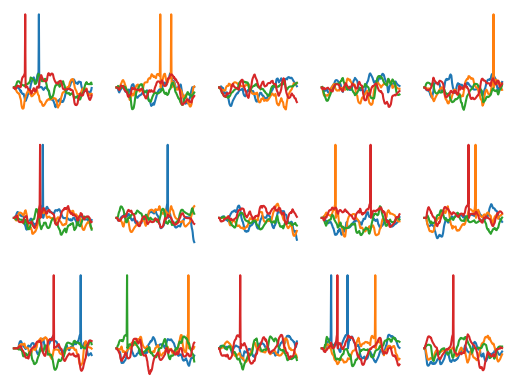

In [ ]:
# 막전위와 스파이크 발생을 그래프로 출력
# 차원마다 하나의 그래프를 가지고 있음

print("mem_rec.shape:", mem_rec.shape)
print("spk_rec.shape:", spk_rec.shape)

fig=plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)

As you can see, our random initialization gives us some sporadic spiking. Thus far, we have only an input layer and a spiking layer, which should become our hidden layer. Next, we will have to add a readout layer to our network.

보시다시피, 무작위 초기화로 인해 산발적인 스파이크가 발생합니다. 지금까지는 입력 레이어와 숨겨진 레이어가 될 스파이크 레이어만 있습니다. 다음으로 네트워크에 판독 레이어를 추가해야 합니다.

## Adding a readout layer

To use our network as a classifier, we need to have a readout layer on whose output we can define a cost function. There are several possibilities for doing this. For instance, we could count output layer spikes, or we could directly define an objective function on the membrane potential of the output neurons. Here we will follow the latter approach, but keep in mind that there are many other possibilities of defining an output layer and respective cost functions on them.

In the following, we will build the output layer as a population of leaky integrator neurons. The reason for this choice is that leaky integration is the natural way of how neurons receive the spiking output of their brethren. Moreover, because we will need this code again, we combine our code from above plus the added readout layer into a single function.

## 판독 레이어 추가

네트워크를 분류자로 사용하려면 출력에 대한 비용 함수를 정의할 수 있는 판독 레이어가 필요합니다. 이를 수행하는 데는 여러 가지 가능성이 있습니다. 예를 들어, 출력층 스파이크를 계산하거나 출력 뉴런의 막 전위에 대한 목적 함수를 직접 정의할 수 있습니다. 여기서는 후자의 접근 방식을 따르지만, 출력 계층과 해당 비용 함수를 정의하는 다른 많은 가능성이 있다는 점을 염두에 두십시오.

다음에서는 누출 적분기 뉴런의 집단으로 출력 레이어를 구축합니다. 이렇게 선택한 이유는 누출된 통합이 뉴런이 형제의 급증하는 출력을 수신하는 자연스러운 방법이기 때문입니다. 게다가 이 코드가 다시 필요하기 때문에 위의 코드와 추가된 판독 레이어를 단일 함수로 결합합니다.

In [37]:
#SNN 함수 실행코드 

def run_snn(inputs):
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))                          # 입력과 가중치를 계산해 h1을 생성
    syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)   # 시냅스 전위 초기화
    mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)   # 막전위 초기화

    mem_rec = []
    spk_rec = []

    # Compute hidden layer activity
    for t in range(nb_steps):
        mthr = mem-1.0
        out = spike_fn(mthr)
        rst = out.detach() # We do not want to backprop through the reset

        new_syn = alpha*syn +h1[:,t]
        new_mem = (beta*mem +syn)*(1.0-rst)

        mem_rec.append(mem)
        spk_rec.append(out)
        
        mem = new_mem
        syn = new_syn

    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)

    # Readout layer
    h2 = torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out_rec = [out]
    for t in range(nb_steps):
        new_flt = alpha*flt +h2[:,t]
        new_out = beta*out +flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs

We can now run this code and plot the output layer "membrane potentials" below. As desired, these potentials do not have spikes riding on them.

이제 이 코드를 실행하고 아래 출력 레이어 "막 전위"를 플롯할 수 있습니다. 원하는 대로 이러한 전위에는 스파이크가 발생하지 않습니다.

In [38]:
# 입력 데이터로 SNN 학습 실행
out_rec,other_recs = run_snn(x_data)

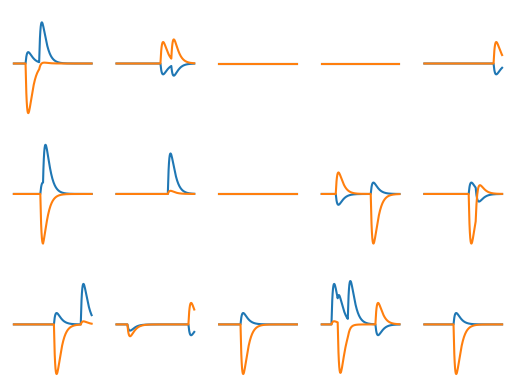

In [40]:
fig=plt.figure(dpi=100) # dpi: 그림의 해상도 지정
plot_voltage_traces(out_rec)

By preventing the output neurons from spiking themselves, we can define a relatively smooth objective on their membrane voltages directly. Specifically, we use the maximum voltage over time of each output unit
$$\hat U^\mathrm{out}_i=\max_t U^\mathrm{out}_i(t)$$
and then use this vector as input for either an argmax to compute the classification accuracy or as we will see below as input for a standard softmax function in conjunction with a negative log-likelihood loss for optimizing the weights in the network. 

Let us first compute the classification accuracy of this random network. We will see that this accuracy is somewhere around 50% as it should be since that corresponds to the chance level of our synthetic task.

출력 뉴런이 스스로 급증하는 것을 방지함으로써 우리는 막 전압에 대해 상대적으로 부드러운 목표를 직접 정의할 수 있습니다. 구체적으로, 각 출력 장치의 시간에 따른 최대 전압을 사용합니다.
$$\hat U^\mathrm{out}_i=\max_t U^\mathrm{out}_i(t)$$
그런 다음 이 벡터를 argmax에 대한 입력으로 사용하여 분류 정확도를 계산하거나 아래에서 볼 수 있듯이 네트워크의 가중치를 최적화하기 위한 음의 로그 우도 손실과 함께 표준 소프트맥스 함수에 대한 입력으로 사용합니다.

먼저 이 무작위 네트워크의 분류 정확도를 계산해 보겠습니다. 이 정확도는 합성 작업의 확률 수준에 해당하므로 대략 50% 정도라는 것을 알 수 있습니다.

In [45]:
def print_classification_accuracy():
    """ Dirty little helper function to compute classification accuracy. """
    output, _ = run_snn(x_data)  # 모델 학습
    m, _= torch.max(output,1) # max over time
    _, am=torch.max(m,1) # argmax over output units
    acc = np.mean((y_data==am).detach().cpu().numpy()) # compare to labels
    print("Accuracy %.3f"%acc)
    
print_classification_accuracy()

Accuracy 0.547


## Supervised learning

So far, we have built the infrastructure to simulate our spiking neural network, but we have worked with purely random network weights thus far.
The vanilla method to adjust network weights to decrease the specified objective is gradient descent. 
Machine learning libraries like Tensorflow and PyTorch make implementing gradient descent a breeze.
We first perform gradient descent on the correct gradient and use this as a motivation for introducing surrogate gradients.
Here we go.

## 지도 학습

지금까지 우리는 스파이크 신경망을 시뮬레이션하기 위한 인프라를 구축했지만 지금까지는 순전히 무작위 네트워크 가중치를 사용하여 작업했습니다.
지정된 목표를 줄이기 위해 네트워크 가중치를 조정하는 기본 방법은 경사하강법입니다.
Tensorflow 및 PyTorch와 같은 기계 학습 라이브러리를 사용하면 경사 하강법을 쉽게 구현할 수 있습니다.
먼저 올바른 그래디언트에 대해 그래디언트 하강을 수행하고 이를 대리 그래디언트 도입을 위한 동기로 사용합니다.
여기 있습니다.

### Supervised learning with the true gradient

In [42]:
params = [w1, w2]                                                   # 가중치 매개변수 지정
optimizer = torch.optim.Adam(params, lr=2e-3, betas=(0.9,0.999))    # 최적화 함수 지정

log_softmax_fn = nn.LogSoftmax(dim=1)                               # 출력층 활성화 함수로 소프트맥스 지정

# 소프트맥스 함수를 지난 후 사용하는 경우가 일반적
# The negative log likelihood loss function
loss_fn = nn.NLLLoss()

# The optimization loop
loss_hist = []
for e in range(1000):   # 일반적인 학습의 과정과 동일
    # run the network and get output
    output,_ = run_snn(x_data) 
    # compute the loss
    m,_=torch.max(output,1)
    log_p_y = log_softmax_fn(m) 
    loss_val = loss_fn(log_p_y, y_data)
    
    if e % 100 == 0:
        print("loss_val:", loss_val)

    # update the weights
    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()
    
    # store loss value
    loss_hist.append(loss_val.item())
    
loss_hist_true_grad = loss_hist # store for later use

loss_val: tensor(0.6820, grad_fn=<NllLossBackward0>)
loss_val: tensor(0.6809, grad_fn=<NllLossBackward0>)
loss_val: tensor(0.6802, grad_fn=<NllLossBackward0>)
loss_val: tensor(0.6797, grad_fn=<NllLossBackward0>)
loss_val: tensor(0.6793, grad_fn=<NllLossBackward0>)
loss_val: tensor(0.6790, grad_fn=<NllLossBackward0>)
loss_val: tensor(0.6788, grad_fn=<NllLossBackward0>)
loss_val: tensor(0.6786, grad_fn=<NllLossBackward0>)
loss_val: tensor(0.6784, grad_fn=<NllLossBackward0>)
loss_val: tensor(0.6782, grad_fn=<NllLossBackward0>)


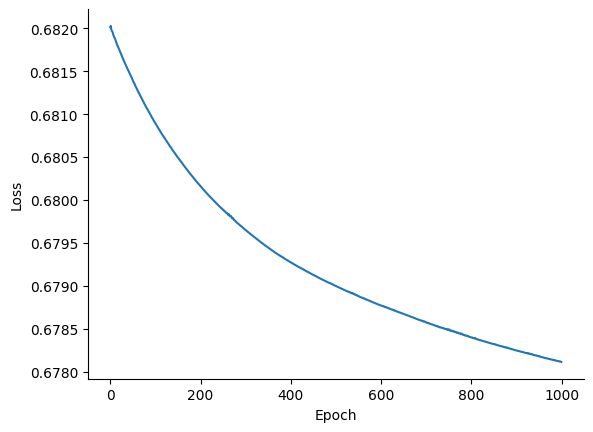

In [43]:
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()

In [46]:
print_classification_accuracy()

Accuracy 0.547


We appreciate that loss decreases over iterations and converges towards a steady state. The classification accuracy, however, does not seem to improve dramatically throughout the optimization. What a shame! 

The underlying reason is that the nonlinearity of the hidden units have zero derivatives everywhere except at threshold crossings, where they become infinite. In practice that means that weight updates in the hidden layer vanish and the weights remain unmodified. By plotting the hidden layer activations and comparing them with what we have plotted before, we will see that these activations have not changed at all. Thus no learning happens in the hidden layer. The reason why the loss decreased initially during optimization is that the output layer weights could still change and allow for some improvement (even if it was very little).

To improve performance, we need to get the hidden layer units to take part in learning. To achieve this, we will introduce a surrogate gradient in the next section.

반복을 통해 손실이 감소하고 안정적인 상태로 수렴된다는 점을 잘 알고 있습니다. 그러나 분류 정확도는 최적화 전반에 걸쳐 크게 향상되지 않는 것 같습니다. 정말 부끄러운 일입니다!

근본적인 이유는 은닉 유닛의 비선형성이 무한해지는 임계값 교차점을 제외하고 모든 곳에서 도함수가 0이기 때문입니다. 실제로 이는 숨겨진 레이어의 가중치 업데이트가 사라지고 가중치가 수정되지 않은 상태로 유지됨을 의미합니다. 은닉층 활성화를 플롯팅하고 이를 이전에 플롯한 것과 비교하면 이러한 활성화가 전혀 변경되지 않았음을 알 수 있습니다. 따라서 은닉층에서는 학습이 일어나지 않습니다. 최적화 중에 초기에 손실이 감소한 이유는 출력 레이어 가중치가 여전히 변경되어 약간의 개선이 가능하기 때문입니다(아주 작더라도).

성능을 향상시키기 위해서는 은닉층 단위가 학습에 참여하도록 해야 합니다. 이를 달성하기 위해 다음 섹션에서 대리 그래디언트를 소개하겠습니다.

In [47]:
output,other_recordings = run_snn(x_data)
mem_rec, spk_rec = other_recordings

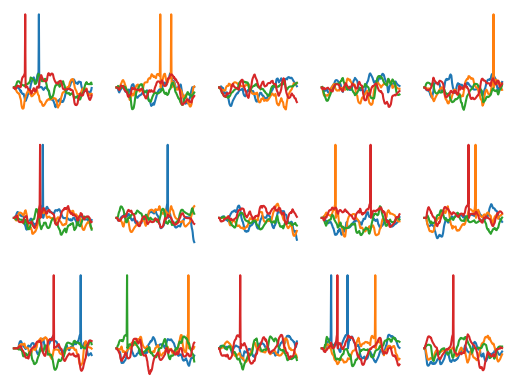

In [48]:
fig=plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)

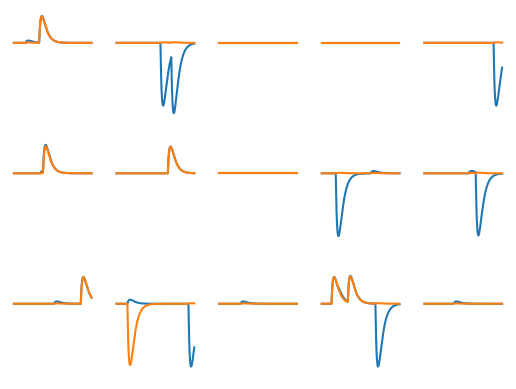

In [49]:
fig=plt.figure(dpi=100)
plot_voltage_traces(output)

### Supervised learning with surrogate gradients

In the last section, we saw that the hidden layer units did not participate.
The underlying reason is that the partial derivative of the step function we used has a vanishing derivative everywhere (except at zero where it becomes infinite).

Most conventional neural networks avoid this problem by choosing a nonlinearity with non-zero partial derivative. For instance, sigmoidal or tanh units were standard during the beginnings of neural networks research. Today, ReLUs are more common. Importantly, all these activation functions have substantial non-zero support, which allows gradients to flow (to a greater or lesser extent).

What do we if we want to stick to our binary nonlinearity? There have been several approaches to tackle this problem. Here we use one such strategy which has been applied successfully to spiking neural networks: We use a surrogate gradient approach.

The idea behind a surrogate gradient is dead simple. Instead of changing the nonlinearity itself, we only change the gradient. Thus we use a different "surrogate" gradient to optimize parameters that would otherwise have a vanishing gradient.

<img src="figures/surrgrad/surrgrad.png" width="450">
Specifically, we use the partial derivative of a function which to some extent approximates the stepfunction $\Theta(x)$.
In what follows, chiefly, we will use (up to rescaling) the partial derivative of a fast sigmoid function $\sigma(x)$. 
While $\Theta$ is invariant to multiplicative rescaling, $\sigma$ isn't. Thus we have to introduce a scale parameter.

### 대리 그라디언트를 사용한 지도 학습

마지막 섹션에서는 숨겨진 레이어 단위가 참여하지 않는 것을 확인했습니다.
근본적인 이유는 우리가 사용한 계단 함수의 부분 도함수는 어디에서나 (무한이 되는 0을 제외하고) 사라지는 도함수를 갖는다는 것입니다.

대부분의 기존 신경망은 0이 아닌 편도함수를 갖는 비선형성을 선택하여 이 문제를 피합니다. 예를 들어, S자형 또는 tanh 단위는 신경망 연구 초기에는 표준이었습니다. 오늘날에는 ReLU가 더 일반적입니다. 중요한 것은 이러한 모든 활성화 함수가 0이 아닌 실질적인 지원을 제공하여 기울기가 어느 정도 흐르도록 허용한다는 것입니다.

이진 비선형성을 고수하려면 어떻게 해야 합니까? 이 문제를 해결하기 위해 여러 가지 접근 방식이 있었습니다. 여기에서는 스파이킹 신경망에 성공적으로 적용된 전략 중 하나를 사용합니다. 즉, 대리 그래디언트 접근 방식을 사용합니다.

대리 그라디언트 뒤에 숨은 아이디어는 매우 간단합니다. 비선형성 자체를 변경하는 대신 기울기만 변경합니다. 따라서 우리는 다른 "대리" 그래디언트를 사용하여 그래디언트가 사라지는 매개변수를 최적화합니다.

<img src="Figures/surrgrad/surrgrad.png" width="450">
구체적으로, 우리는 어느 정도 단계함수 $\Theta(x)$에 근접하는 함수의 편도함수를 사용합니다.
다음에서는 주로 빠른 시그모이드 함수 $\sigma(x)$의 부분 도함수를 사용합니다(재척도 조정까지).
$\Theta$는 곱셈 재조정에 변하지 않지만 $\sigma$는 그렇지 않습니다. 따라서 우리는 scale 매개변수를 도입해야 합니다.

In [50]:
# 세로게이 -> SurrGradient surrocate Gradient -> 은닉 유닛의 임계값 교차점을 제외하면 모두 도함수가 0이기 때문에 가중치가 잘 수정되지 않는 문제를 해결하기 위해서
class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient. By subclassing torch.autograd.Function, 
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid 
    as this was done in Zenke & Ganguli (2018).
    """
    
    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which 
        we need to later backpropagate our error signals. To achieve this we use the 
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        Here we use the normalized negative part of a fast sigmoid 
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad
    
# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
spike_fn  = SurrGradSpike.apply

In [52]:
# The following lines will reinitialize the weights
# torch.nn.init.normal_(초기화 가중치 텐서, 정규 분포의 평균 값, 정규 분포의 표준 편차)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))
print("init done")

init done


In [54]:
params = [w1, w2]
optimizer = torch.optim.Adam(params, lr=2e-3, betas=(0.9,0.999))

log_softmax_fn = nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss()

loss_hist = []
for e in range(1000):
    output,_ = run_snn(x_data)
    m,_=torch.max(output,1)
    log_p_y = log_softmax_fn(m)
    loss_val = loss_fn(log_p_y, y_data)

    if e % 100 == 0:
        print("loss_val:", loss_val)

    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()
    loss_hist.append(loss_val.item())

loss_val: tensor(0.5403, grad_fn=<NllLossBackward0>)
loss_val: tensor(0.3259, grad_fn=<NllLossBackward0>)
loss_val: tensor(0.2137, grad_fn=<NllLossBackward0>)
loss_val: tensor(0.1564, grad_fn=<NllLossBackward0>)
loss_val: tensor(0.1312, grad_fn=<NllLossBackward0>)
loss_val: tensor(0.1037, grad_fn=<NllLossBackward0>)
loss_val: tensor(0.0784, grad_fn=<NllLossBackward0>)
loss_val: tensor(0.0790, grad_fn=<NllLossBackward0>)
loss_val: tensor(0.0706, grad_fn=<NllLossBackward0>)
loss_val: tensor(0.0638, grad_fn=<NllLossBackward0>)


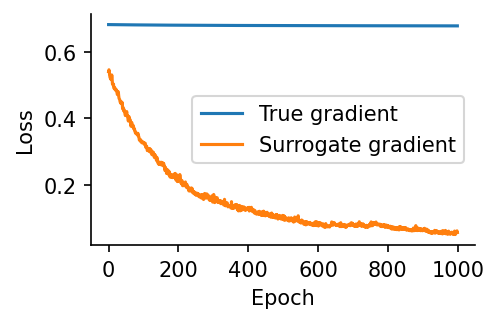

In [55]:
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(loss_hist_true_grad, label="True gradient")
plt.plot(loss_hist, label="Surrogate gradient")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
sns.despine()

In [56]:
output,other_recordings = run_snn(x_data)
mem_rec, spk_rec = other_recordings

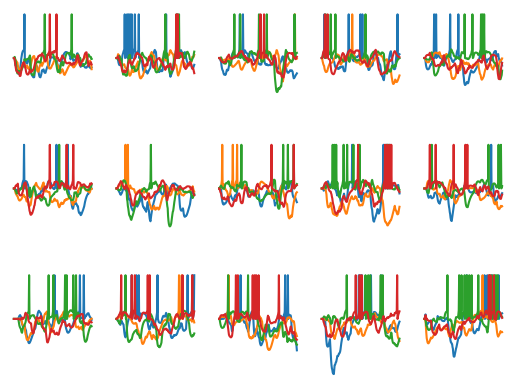

In [57]:
fig=plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)

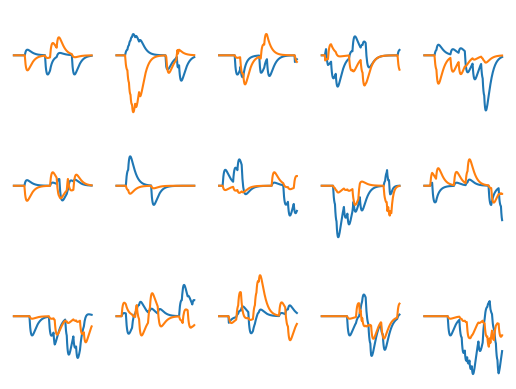

In [58]:
fig=plt.figure(dpi=100)
plot_voltage_traces(output)

In [59]:
output,_ = run_snn(x_data)
m,_=torch.max(output,1)

# Compute training accuracy
_,am=torch.max(m,1)
acc = np.mean((y_data==am).detach().cpu().numpy())
print("Accuracy %f"%acc)

Accuracy 0.968750


<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.